In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [2]:
df=pd.read_csv(r'C:\Users\lamisa\Desktop\Recomender system\Electronics.csv',names=["user_id", "product_id", "ratings", "timestamp"])
df.head(10)

,user_id,product_id,ratings,timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400
3,0060009810,A2T278FKFL3BLT,4.0,1025395200
4,0060009810,A2ZUXVTW8RXBXW,5.0,1025222400
5,0060009810,A21JDG4HA6OLPF,4.0,1024963200
6,0060009810,A2NCADLQY962YD,5.0,1024704000
7,0060786817,A2UNA438B0FRA8,5.0,1138233600
8,0060786817,A2NQQSHSQKKGEX,5.0,1137801600
9,0060786817,A5EXND10WD4PM,3.0,1137542400


In [3]:
#drop timestamp column
df.drop(['timestamp'], axis=1,inplace=True)

print(df.shape)

#check for missing values
df.isna().sum()

(20994353, 3)


user_id       0
product_id    0
ratings       0
dtype: int64

In [4]:
df=df.iloc[:1048576,0:]
df.shape

(1048576, 3)

In [5]:
# number of unique users
print("number of unique users: "+str(len(df.user_id.unique())))
#number of unique products
print("number of unique products: "+str(len(df.product_id.unique())))

number of unique users: 12759
number of unique products: 824624


In [12]:
#no of ratings per product
df.product_id.value_counts()[:5]

A5JLAU2ARJ0BO     241
A231WM2Z2JL0U3    172
A6FIAB28IS79       88
AT6CZDCP4TRGA      79
A3OXHLG6DIBRW8     63
Name: product_id, dtype: int64

In [13]:
products=pd.DataFrame(df.groupby('product_id')['ratings'].count())
products.head()

,ratings
product_id,
A0004478EF5NFPHLGCWG,1
A000681618A3WRMCK53V,1
A0008898NGEXICE0F146,2
A00101847G3FJTWYGNQA,1
A0010606488RW7ZH6EP7,1


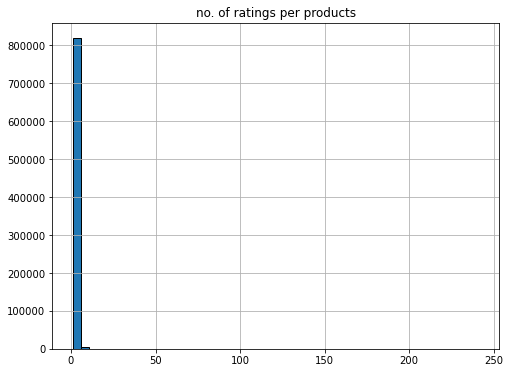

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
plt.title('no. of ratings per products')
products['ratings'].hist(bins=50)

In [18]:
#no of ratings per users
df.user_id.value_counts()[:5]

B000BQ7GW8    13768
B0006BB9MG     7593
B000A6PPOK     6398
B00004ZCJJ     5697
B00004ZCJI     5697
Name: user_id, dtype: int64

In [19]:
users=pd.DataFrame(df.groupby('user_id')['ratings'].count())
users.head()

,ratings
user_id,
0060009810,7
0060786817,45
0070524076,12
0101635370,68
0151004714,48


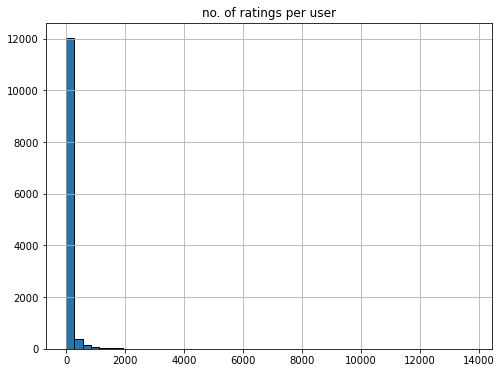

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
plt.title('no. of ratings per user')
users['ratings'].hist(bins=50)

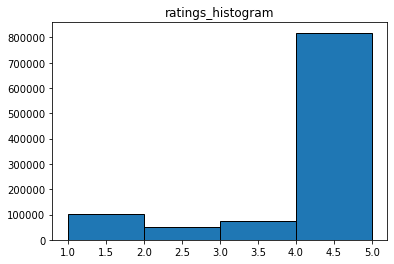

In [21]:
#distribution of ratings
plt.hist(df.ratings, bins = [1,2,3,4,5],ec='black') 
plt.title("ratings_histogram") 
plt.show()

In [31]:
#filter out products with less than 20 reviews
ratings_df=df.groupby('product_id').filter(lambda x: x['ratings'].count()>20)

In [32]:
## item_based colleaborative filtering
##memory based algorithm
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[["user_id", "product_id", "ratings"]], reader)

In [33]:
#split data
train_data, test_data = train_test_split(data, test_size=0.3,random_state=10)

In [34]:
#tuning hyper parameters
similarity_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}
param_grid = {"sim_options": similarity_options}
grid_search = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
grid_search.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [35]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

1.038932115653137
{'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}}


In [36]:

sim_options = {
    "name": "msd",
    "user_based": False,  # Compute  similarities between items
    "min_support": 5
}
algo = KNNWithMeans(sim_options=sim_options)

In [37]:
algo.fit(train_data)
predictions=algo.test(test_data)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0110


1.0109911818184498

In [38]:
predicted_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
predicted_df.head(5)

,uid,iid,rui,est,details
0,B0002Z240W,A2R6RA8FRBS608,5.0,4.320545,"{'was_impossible': True, 'reason': 'User and/o..."
1,B000B8UOTS,A2JRDFIGWTX50J,3.0,3.736842,"{'actual_k': 0, 'was_impossible': False}"
2,B0000BVYT3,A1T1YSCDW0PD25,5.0,4.208333,"{'actual_k': 0, 'was_impossible': False}"
3,B00009UTZA,A1H4WLPFV59XMA,5.0,5.000000,"{'actual_k': 0, 'was_impossible': False}"
4,B00006J055,AT6CZDCP4TRGA,1.0,4.320545,"{'was_impossible': True, 'reason': 'User and/o..."


In [39]:
def get_Iu(uid):
    #computes the number of items rated by the user
    
    try:
        return len(train_data.ur[train_data.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    #computes the number of users that have rated the item.
    
    try: 
        return len(train_data.ir[train_data.to_inner_iid(iid)])
    except ValueError:
        return 0

In [40]:
predicted_df['Iu'] = predicted_df.uid.apply(get_Iu)
predicted_df['Ui'] = predicted_df.iid.apply(get_Ui)
predicted_df['err'] = abs(predicted_df.est - predicted_df.rui)
best_predictions = predicted_df.sort_values(by='err')[:10]
worst_predictions = predicted_df.sort_values(by='err')[-10:]

In [41]:
print("best predictions: ")
best_predictions.head(10)

best predictions: 


,uid,iid,rui,est,details,Iu,Ui,err
688,B00006I53S,A2LCE1D0TW2XY0,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",3,15,0.0
212,B0002JFN60,A31N0XY2UTB25C,5.0,5.0,"{'actual_k': 6, 'was_impossible': False}",6,36,0.0
1036,B00007M8H7,A1JZFGZEZVWQPY,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,22,0.0
851,B0006BB9MG,A1T1YSCDW0PD25,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",7,24,0.0
1126,B0009VT9O8,A3REK3OFONWB1Q,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",3,14,0.0
1100,B0009VT9O8,A1QVFHPY8418HC,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,14,0.0
947,B00067PS7W,A33775AIB1A664,4.0,4.0,"{'actual_k': 3, 'was_impossible': False}",3,15,0.0
599,B00009XVA3,A2PSD2R9A1CXG7,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,23,0.0
1154,B00005121B,A31N0XY2UTB25C,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",2,36,0.0
314,B000068NYI,A6FIAB28IS79,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,61,0.0


In [42]:
print("worst predictions: ")
worst_predictions.head(10)

worst predictions: 


,uid,iid,rui,est,details,Iu,Ui,err
891,B0002G81J4,A5JLAU2ARJ0BO,1.0,4.320545,"{'was_impossible': True, 'reason': 'User and/o...",0,158,3.320545
518,B000A3NHJS,A7QT04TT3PXOP,1.0,4.320545,"{'was_impossible': True, 'reason': 'User and/o...",0,16,3.320545
181,B00006HYMK,A12DLJESJKM1OQ,1.0,4.375000,"{'actual_k': 0, 'was_impossible': False}",1,24,3.375000
1048,B000261N6M,A23ONMGKEWDG4M,1.0,4.428571,"{'actual_k': 0, 'was_impossible': False}",1,21,3.428571
542,B0000658CH,A23ONMGKEWDG4M,1.0,4.428571,"{'actual_k': 0, 'was_impossible': False}",2,21,3.428571
222,B0002JFOKK,AVSMRPI23DQI2,1.0,4.500000,"{'actual_k': 0, 'was_impossible': False}",8,16,3.500000
390,B0002JFN60,AVSMRPI23DQI2,1.0,4.500000,"{'actual_k': 0, 'was_impossible': False}",6,16,3.500000
169,B00006HYKM,A5JLAU2ARJ0BO,1.0,4.591160,"{'actual_k': 1, 'was_impossible': False}",4,158,3.591160
39,B0000AAAPF,A2XRMQA6PJ5ZJ8,1.0,4.628571,"{'actual_k': 0, 'was_impossible': False}",2,35,3.628571
934,B0000C0XS0,A3977M5S0GIG5H,1.0,4.764706,"{'actual_k': 0, 'was_impossible': False}",1,17,3.764706


In [ ]:
#model based approach
#incomplete
param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])